In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from merge import merge_func

import nltk
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

In [102]:
ratings_file = 'BX-Ratings.csv'
books_file = 'BX-Books.csv'
users_file = 'BX-Users.csv'
output_file = 'Final_Merged.csv'

In [103]:
ratings = pd.read_csv(ratings_file)
books = pd.read_csv(books_file)
users = pd.read_csv(users_file)

In [104]:
# normalisation in users city, state, country

users["User-Country"] = users["User-Country"].str.replace('"', ' ').str.lower().str.strip().replace('', pd.NA)
users["User-City"] = users["User-City"].str.replace('"', ' ').str.lower().str.strip().replace('', pd.NA)
users["User-State"] = users["User-State"].str.replace('"', ' ').str.lower().str.strip().replace('', pd.NA)
users["User-Age"] = users["User-Age"].str.replace('"', ' ').str.strip().replace('', pd.NA)

users.to_csv('normalise_users.csv', index=False)
print(users)

       User-ID    User-City  User-State User-Country User-Age
0            8      timmins     ontario       canada      NaN
1            9   germantown   tennessee          usa      NaN
2           16  albuquerque  new mexico          usa      NaN
3           17   chesapeake    virginia          usa      NaN
4           19       weston        <NA>          NaN       14
...        ...          ...         ...          ...      ...
48294   278846      toronto     ontario       canada       23
48295   278849   georgetown     ontario       canada       23
48296   278851       dallas       texas          usa       33
48297   278852     brisbane  queensland    australia       32
48298   278854     portland      oregon          usa      NaN

[48299 rows x 5 columns]


In [105]:
# check missing data
missing_books = books.isna().sum()
print(missing_books)
print(" ")

missing_users = users.isna().sum()
print(missing_users)
print(" ")

missing_ratings = ratings.isna().sum()
print(missing_ratings)

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Book-Publisher         0
dtype: int64
 
User-ID             0
User-City          61
User-State        666
User-Country      669
User-Age        18952
dtype: int64
 
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [106]:
# filter out data has vaild state input
validstate_df = users.dropna(subset=['User-State'])
# create a dictionary mapping city to state
map_city_tostate = validstate_df.groupby('User-City')['User-State'].first().to_dict()
# filtered missing state
missing_state = users[users['User-State'].isnull()]
# base on the given state name, try to fill in missing country
for index, row in missing_state.iterrows():
    city = row['User-City']
    if city in map_city_tostate:
        users.at[index, 'User-State'] = map_city_tostate[city]


# filter out data has vaild country input
validcountry_df = users.dropna(subset=['User-Country'])
# create a dictionary mapping state to country
map_state_tocountry = validcountry_df.groupby('User-State')['User-Country'].first().to_dict()
missing_country = users[users['User-Country'].isnull()]
for index, row in missing_country.iterrows():
    state = row['User-State']
    if state in map_state_tocountry:
        users.at[index, 'User-Country'] = map_state_tocountry[state]


# filter out data has vaild country input
validcountry_df = users.dropna(subset=['User-Country'])
# create a dictionary mapping state to country
map_city_tocountry = validcountry_df.groupby('User-State')['User-Country'].first().to_dict()
missing_country = users[users['User-Country'].isnull()]
print(len(missing_country))
for index, row in missing_country.iterrows():
    city = row['User-City']
    if city in map_city_tocountry:
        users.at[index, 'User-Country'] = map_city_tocountry[city]


# get rid of rows with empty values for city, state, and country
cleaned_users = users.dropna(subset=['User-City', 'User-State', 'User-Country'])
cleaned_users.to_csv('cleaned_users.csv', index=False)

# display the number of users we get rid of
na_columns = ['User-City', 'User-State', 'User-Country']
na_df = users[users[na_columns].isnull().any(axis=1)]
na_df

52


,User-ID,User-City,User-State,User-Country,User-Age
385,2197,NaN,travelling,canada,26
616,3569,NaN,n/a,usa,NaN
731,4221,NaN,connecticut,usa,NaN
1904,11676,NaN,n/a,n/a,NaN
1913,11737,cesena,<NA>,NaN,31
...,...,...,...,...,...
47160,271844,elfin forest,<NA>,NaN,93
47582,274808,paynesville,<NA>,usa,17
47963,277124,NaN,<NA>,canada,NaN
48155,278112,middleburg hts,<NA>,usa,70


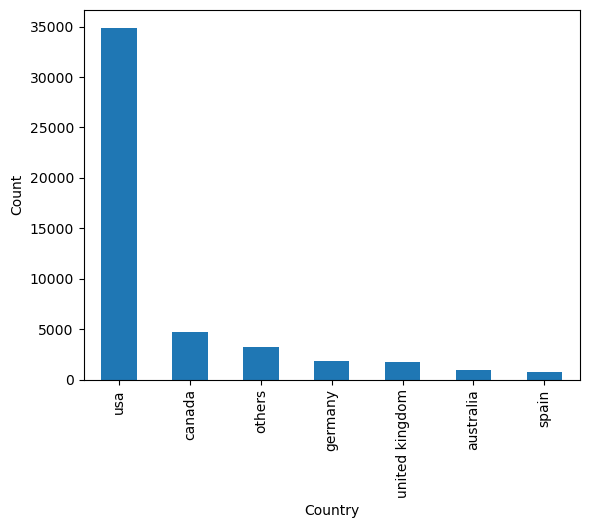

In [109]:
# identify countries have less than 10 users and combine them into a category called others
countries_to_combine = users['User-Country'].value_counts()[users['User-Country'].value_counts()<500].index

users.loc[users['User-Country'].isin(countries_to_combine), 'User-Country'] = "others"

users['User-Country'].value_counts().plot(kind='bar')

plt.xlabel('Country')
plt.ylabel('Count')
plt.show()